In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob
import sys
import sklearn.metrics as metrics
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
# This is needed to display the images.
%matplotlib inline

# Detect the traffic lights in an image

### Download pretrained model

In [9]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

### Code for detection

In [10]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes


In [11]:
tlc=TLClassifier()

In [12]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

In [14]:
%time
test_file = "archive/daySequence1/daySequence1/frames/daySequence1--02000.jpg"
# test_file = "/kaggle/input/lisa-traffic-light-dataset/sample-dayClip6/sample-dayClip6/frames/dayClip6--00332.jpg"
from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)
plt.imshow(image_np)

CPU times: total: 0 ns
Wall time: 0 ns


FileNotFoundError: [Errno 2] No such file or directory: '../archive/daySequence1/daySequence1/frames/daySequence1--02000.jpg'

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


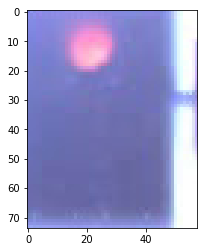

In [82]:
%time
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)
if len(boxes)>0:
    cropped_image=crop_roi_image(image_np,boxes[0])
    plt.imshow(cropped_image)
    immmm = Image.fromarray(cropped_image)
    immmm.save('./temp.jpg')
else:
    print('No traffic light was detected or light is off')

# CLASSIFICATION

In [9]:
from pathlib import Path
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

In [10]:
IMAGE_SIZE = [224, 224]

## Transfer Learning

In [11]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 3s 0us/step


In [12]:
for layer in inception.layers:
    layer.trainable = False

In [13]:
x = Flatten()(inception.output)

In [14]:
train_path = '../input/cropped-lisa-traffic-light-dataset/cropped_lisa_1/train_1'
valid_path = '../input/cropped-lisa-traffic-light-dataset/cropped_lisa_1/val_1'

In [15]:
folders = glob(train_path+'/*')

In [16]:
prediction = Dense(len(folders), activation='softmax')(x)

In [17]:
model = Model(inputs=inception.input, outputs=prediction)

In [18]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

Found 32797 images belonging to 7 classes.


In [21]:
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 3737 images belonging to 7 classes.


In [22]:
print(training_set.class_indices)

{'go': 0, 'goForward': 1, 'goLeft': 2, 'stop': 3, 'stopLeft': 4, 'warning': 5, 'warningLeft': 6}


In [23]:
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/10
1025/1025 [==============================] - 497s 485ms/step - loss: 6.7410 - acc: 0.7221 - val_loss: 7.5460 - val_acc: 0.7948
Epoch 2/10
1025/1025 [==============================] - 378s 369ms/step - loss: 4.0905 - acc: 0.8143 - val_loss: 9.3889 - val_acc: 0.7862
Epoch 3/10
1025/1025 [==============================] - 377s 368ms/step - loss: 3.5742 - acc: 0.8511 - val_loss: 8.9369 - val_acc: 0.6741
Epoch 4/10
1025/1025 [==============================] - 378s 369ms/step - loss: 2.9867 - acc: 0.8668 - val_loss: 10.0631 - val_acc: 0.5470
Epoch 5/10
1025/1025 [==============================] - 379s 369ms/step - loss: 2.7259 - acc: 0.8773 - val_loss: 10.0618 - val_acc: 0.7776
Epoch 6/10
1025/1025 [==============================] - 378s 369ms/step - loss: 2.7807 - acc: 0.8831 - val_loss: 8.4165 - val_acc: 0.6278
Epoch 7/10
1025/1025 [==============================] - 378s 369ms/step - loss: 2.5475 - acc: 0.8889 - val_loss: 11.9998 - val_acc: 0.4902
Epoch 8/10
1025/1025 [=========

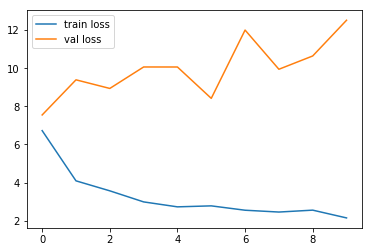

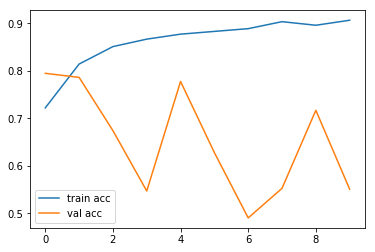

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [26]:
batch_size = 32
def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,7))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

val_labels, val_preds = true_and_predicted_labels(val_set)

In [54]:
a = val_preds
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

In [59]:
print(classification_report(val_labels, a))

              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1372
           1       1.00      0.19      0.32        21
           2       0.04      0.31      0.07       109
           3       0.77      0.69      0.73      1777
           4       0.06      0.03      0.04       345
           5       0.36      0.38      0.37       108
           6       0.00      0.00      0.00         5

   micro avg       0.55      0.55      0.55      3737
   macro avg       0.43      0.31      0.31      3737
weighted avg       0.66      0.55      0.59      3737
 samples avg       0.55      0.55      0.55      3737



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print(confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1)))

[[ 748    0  533   82    0    9    0]
 [   4    4   10    3    0    0    0]
 [  57    0   34   15    0    3    0]
 [ 101    0  233 1220  164   59    0]
 [  64    0   18  252   11    0    0]
 [  35    0   23    8    1   41    0]
 [   2    0    0    2    0    1    0]]


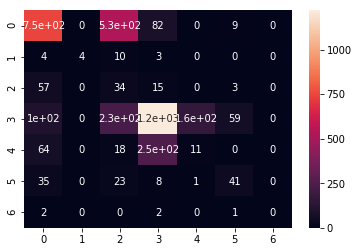

In [76]:
import seaborn as sns
cf_matrix = confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1))
sns.heatmap(cf_matrix, annot=True)

In [63]:
test_img = './temp.jpg'

image = tf.keras.preprocessing.image.load_img(test_img)
im1 = image.resize((224, 224), Image.ANTIALIAS)
input_arr = tf.keras.preprocessing.image.img_to_array(im1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [64]:
all_class_names = training_set.class_indices
all_class_names

{'go': 0,
 'goForward': 1,
 'goLeft': 2,
 'stop': 3,
 'stopLeft': 4,
 'warning': 5,
 'warningLeft': 6}

stop


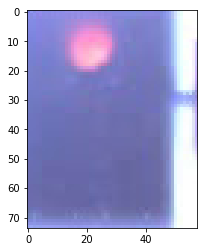

In [83]:
pos_pred = predictions.argmax()
key_list = list(all_class_names.keys())
val_list = list(all_class_names.values())
position = val_list.index(pos_pred)
print(key_list[position])
plt.imshow(cropped_image)